# Deep Neural Network
A Deep Neural Network is characterized by its **multiple hidden layers**, which enable it to model complex patterns. In contrast, logistic regression is a shallow neural network with only a single layer. By increasing the number of layers and neurons, logistic regression can be extended into a deep neural network, enhancing its capacity for sophisticated data analysis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import f1_score
from sklearn.inspection import DecisionBoundaryDisplay

## Dataset
I am using the **make moons dataset**, used primarily for classification tasks. It is particularly useful for visualizing and testing algorithms on non-linearly separable data.

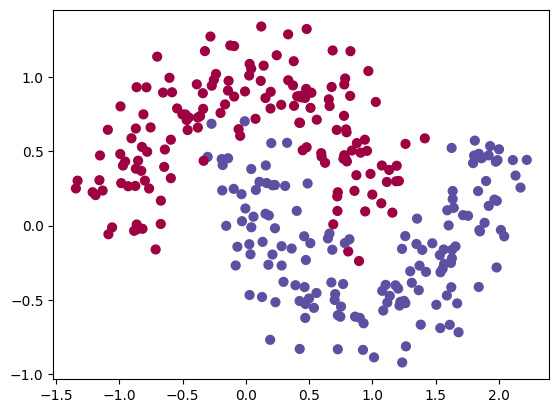

In [ ]:
X, Y = sklearn.datasets.make_moons(n_samples=300, noise=.2)
plt.scatter(X[:,0], X[:,1], s=40, c=Y, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
X_train, X_test = X[:200], X[200:]
Y_train, Y_test = Y[:200], Y[200:]

Y_train = Y_train.reshape((1, -1))
Y_test = Y_test.reshape((1, -1))

X_train = X_train.T
X_test = X_test.T

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2, 200)
(1, 200)
(2, 100)
(1, 100)


# Deep Neural Neural model
I wrote down the implementation of a Deep Neural Network.
- `__init__`: initialize the neural network with given layer dimensions. Randomly initializes weights and sets biases to zero for each layer.
- `linear_forward`: performs the linear part of a layer's forward propagation.
- `sigmoid`: applies the sigmoid activation function, returning the activated output and a cache containing the input.
- `relu`: same thing but with relu activation function, defined as follows:
$$ReLU(z) = max(0,z)$$
- `linear_activation_forward`: it performs forward propagation for a single layer with specified activation.
- `forward_propagation`: it performs forward propagation through all layers of the network.
- `compute_cost`: compute the cost of the network's predictions
- `linear_backward`: it performs the linear part of backpropagation for a single layer.
- `linear_activation_backward`: backpropagation for a single layer.
- `sigmoid_backward`: compute the gradient of the sigmoid activation function.
$$\frac{d\sigma(z)}{dz} = \sigma(z)\big(1 - \sigma(z)\big)$$
- `relu_backward`: compute the gradient of the ReLU activation function.
$$ReLU'(z) = g'(z) = \left\{\begin{split}
0 \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: if \:\: z \le 0 \\
1 \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: if \:\: z > 0
\end{split}\right.$$
- `backward_propagation`: backward propagation through all layers of the network.
- `update_parameters`: updates all parameters of the network using computed gradients.
- `fit`: trains the neural network on the given data.
- `predict`: makes predictions using the trained network.
- `accuracy`: computes and print the accuracy of the model on given data.


In [ ]:
class DeepNeuralNetwork():

  def __init__(self, layer_dims):
    self.parameters = {}
    self.grads = {}
    L = len(layer_dims)

    for l in range(1, L):
      self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))


  def linear_forward(self, A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

  def sigmoid(self, Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

  def relu(self, Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

  def linear_activation_forward(self, A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.sigmoid(Z)

    elif activation == 'relu':
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

  def forward_propagation(self, X):
    caches = []
    A = X
    L = len(self.parameters) // 2

    for l in range(1, L):
      A_prev = A
      A, cache = self.linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], 'relu')
      caches.append(cache)

    AL, cache = self.linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

  def compute_cost(self, AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL)))
    cost = np.squeeze(cost)
    return cost

  def linear_backward(self, dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

  def linear_activation_backward(self, dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == 'relu':
      dZ = self.relu_backward(dA, activation_cache)
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

    elif activation == 'sigmoid':
      dZ = self.sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

  def sigmoid_backward(self, dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    return dZ

  def relu_backward(self, dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

  def backward_propagation(self, AL, Y, caches):
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    self.grads['dA' + str(L-1)], self.grads['dW' + str(L)], self.grads['db' + str(L)] = self.linear_activation_backward(dAL, current_cache, 'sigmoid')

    for l in reversed(range(L-1)):
      current_cache = caches[l]
      dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(self.grads['dA' + str(l+1)], current_cache, 'relu')
      self.grads['dA' + str(l)] = dA_prev_temp
      self.grads['dW' + str(l + 1)] = dW_temp
      self.grads['db' + str(l + 1)] = db_temp

  def update_parameters(self, learning_rate):
    L = len(self.parameters) // 2
    for l in range(L):
      self.parameters['W' + str(l+1)] = self.parameters['W' + str(l+1)] - learning_rate * self.grads['dW' + str(l+1)]
      self.parameters['b' + str(l+1)] = self.parameters['b' + str(l+1)] - learning_rate * self.grads['db' + str(l+1)]

  def fit(self, X, Y, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    np.random.seed(1)
    costs = []
    for i in range(0, num_iterations):
      AL, caches = self.forward_propagation(X)
      cost = self.compute_cost(AL, Y)
      grads = self.backward_propagation(AL, Y, caches)
      self.update_parameters(learning_rate)

      if print_cost and i % 100 == 0:
        print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

  def predict(self, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    probas, caches = self.forward_propagation(X)
    for i in range(0, probas.shape[1]):
      if probas[0,i] > 0.5:
        Y_prediction[0,i] = 1
      else:
        Y_prediction[0,i] = 0

    return Y_prediction

  def accuracy(self, X, Y):
    Y_prediction = self.predict(X)
    print(f"Accuracy: {(100 - np.mean(np.abs(Y_prediction - Y)) * 100):.2f} %")


# Model training
Using `model.fit` I train the network, by using these hyperparameters:
- Learning rate ($α$): 0.8
- Iterations: 10000
- Layer dimensions: [2, 10, 10, 1]

Cost after iteration 0: 0.6931463591177578
Cost after iteration 100: 0.6918676320843176
Cost after iteration 200: 0.6732307893471949
Cost after iteration 300: 0.32818522628998087
Cost after iteration 400: 0.2982355401016343
Cost after iteration 500: 0.12911845985081502
Cost after iteration 600: 0.09459829004129525
Cost after iteration 700: 0.13230969619869393
Cost after iteration 800: 0.055535072221952045
Cost after iteration 900: 0.08234093706614302
Cost after iteration 1000: 0.055471088848281974
Cost after iteration 1100: 0.0512743814892748
Cost after iteration 1200: 0.11812861484414854
Cost after iteration 1300: 0.05048553669545056
Cost after iteration 1400: 0.0576759622582767
Cost after iteration 1500: 0.05250064015981016
Cost after iteration 1600: 0.04992802335946008
Cost after iteration 1700: 0.06424896900970684
Cost after iteration 1800: 0.04942433319645833
Cost after iteration 1900: 0.0720510916426153
Cost after iteration 2000: 0.05740820546715064
Cost after iteration 2100: 0.0

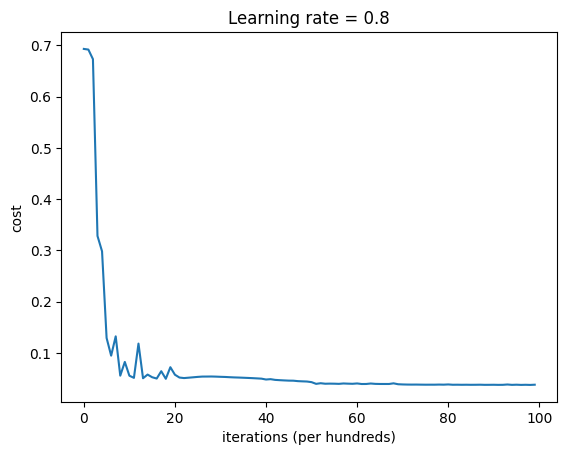

In [ ]:
model = DeepNeuralNetwork([2, 10, 10, 1])
model.fit(X_train, Y_train, learning_rate=0.8, num_iterations=10000, print_cost=True)

# Training results
After the training I evaluated the accuracy of the model and the f1 score, obtaining good results:
- **Accuracy**: 97.00 %
- **F1 score**: 96.73 %

In [ ]:
model.accuracy(X_test, Y_test)
f1 = f1_score(Y_test, model.predict(X_test), average='micro')
print(f"F1-score: {f1*100:.2f} %")

Accuracy: 97.00 %
F1-score: 96.63 %


In [ ]:
def plot_decision_boundary(model, X, y, resolution=0.1):
    """
    Plots the decision boundary for a given classifier model.

    Parameters:
    - model: a trained classifier with a `predict` method.
    - X: array-like, shape (2, n_samples), feature matrix.
    - y: array-like, shape (1, n_samples), target labels.
    - resolution: float, step size of the grid points.
    """
    # Ensure X and y are numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Transpose X if it's in (n_samples, 2) shape
    if X.shape[0] != 2:
        X = X.T

    # Flatten y if it's 2D
    y = y.flatten()

    # Set min and max values for both features
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Flatten the grid points and stack them into a 2D array
    grid_points = np.vstack([xx.ravel(), yy.ravel()])

    # Predict class labels for each point in the grid
    Z = model.predict(grid_points)

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Create a new figure
    plt.figure(figsize=(10, 8))

    # Plot the contour
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')

    # Plot the training points
    scatter = plt.scatter(X[0, :], X[1, :], c=y, edgecolor='k', marker='o', s=50, cmap='coolwarm', alpha=0.8)

    # Add a legend for the classes
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Decision Boundary")
    plt.tight_layout()
    plt.show()

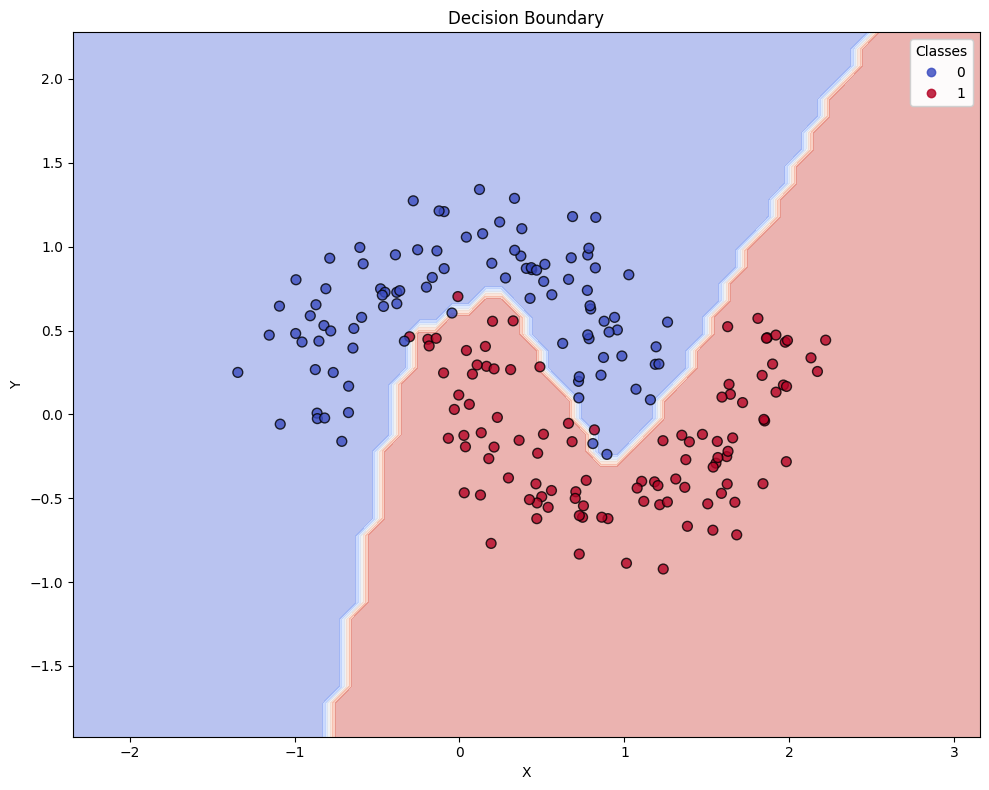

In [ ]:
plot_decision_boundary(model, X_train, Y_train)